In [314]:
import pandas as pd
import numpy as np

data = pd.read_csv("Manhattan_reviews_closed_10.csv")

In [315]:
data = data.drop(['name'], axis=1)

In [316]:
stacked = data.stack().reset_index(drop=True)
df = pd.DataFrame(stacked,columns=['review'])

In [317]:
#Extract negative reviews
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
reviews = np.array(df['review'])

mood=[]
for r in reviews:
    scores = analyzer.polarity_scores(r)
    agg_score = scores['compound']
    final_sentiment = 'positive' if agg_score >= 0 else 'negative'
    mood.append(final_sentiment)

df['sentiment']=mood

In [318]:
neg_df = df[df["sentiment"] == 'negative']

In [319]:
#Clean words
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)


neg_df["review_clean"] = neg_df["review"].apply(lambda x: clean_text(x))

<ipython-input-319-d1e905d711a7>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df["review_clean"] = neg_df["review"].apply(lambda x: clean_text(x))


In [320]:
neg_df = neg_df.drop(['sentiment'],axis=1)

In [321]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf_result = tfidf.fit_transform(neg_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = neg_df.index
neg_df = pd.concat([neg_df, tfidf_df], axis=1)

In [323]:
neg_df.shape

(30, 2467)

In [326]:
tfidf_findcluster = neg_df.drop(['review','review_clean'],axis=1)

In [327]:
#Find cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = range(2,8)

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(tfidf_findcluster)
    centers = clusterer.cluster_centers_

    score = silhouette_score(tfidf_findcluster, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.02781315590842147)
For n_clusters = 3, silhouette score is 0.027637969711270253)
For n_clusters = 4, silhouette score is 0.014058502171691982)
For n_clusters = 5, silhouette score is 0.014972414951339132)
For n_clusters = 6, silhouette score is 0.047085583639696484)
For n_clusters = 7, silhouette score is 0.052891639495271384)


In [328]:
# Create cluster docs
num_clusters = 4
docs = neg_df["review"]

tfidf_vect = TfidfVectorizer(stop_words="english",ngram_range=(2,2)) 
dtm= tfidf_vect.fit_transform(docs)

In [329]:
#Clustering model
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer,cosine_distance
from sklearn import mixture


def cluster_docs(docs, num_clusters=num_clusters, model_type=None):    
    model, tfidf_vect = None, None
    
    tfidf_vect = TfidfVectorizer(stop_words="english",ngram_range=(2,2)) 
    dtm= tfidf_vect.fit_transform(docs)
    
    if model_type == 1:
        clusterer = KMeansClusterer(num_clusters, cosine_distance,repeats=20)
        model = clusterer.cluster(dtm.toarray(),assign_clusters=True)
    if model_type == 2:
        km = KMeans(n_clusters=num_clusters, n_init=20, random_state = 42).fit(dtm)
        model=km.fit(dtm)
    if model_type == 3:
        gmm = mixture.GaussianMixture(n_components=num_clusters,covariance_type='diag',n_init=20, random_state=42)
        model = gmm.fit(dtm.toarray())
        
    return model, tfidf_vect

def interpret_cluster(model, TfidfVect, model_type):
    
    model, tfidf_vect = cluster_docs(docs, num_clusters=num_clusters, model_type = model_type)
      
    result = None    
    if model_type == 1:
        clusterer = KMeansClusterer(num_clusters, cosine_distance, repeats=20)
        model = clusterer.cluster(dtm.toarray(), \
                             assign_clusters=True)
        centroids=np.array(clusterer.means())
    if model_type == 2:
        centroids=model.cluster_centers_
    if model_type == 3:
        centroids=model.means_
        
    sorted_centroids=centroids.argsort()[:, ::-1]
    
    results=[]
    voc_lookup= tfidf_vect.get_feature_names()
    for i in range(num_clusters):
        top_words=[voc_lookup[word_index] \
               for word_index in sorted_centroids[i, :20]]
        results.append(top_words)
   
    return results  

In [330]:
if __name__ == "__main__":
    
    
    model_dict = {1: "KMeans with Cosine Distance",
                 2: "KMeans with Euclidean Distance",
                 3: "GMM"}
    
    for model_type in [1,2, 3]:
        print("\n")
        print("======= " + model_dict[model_type]+" =======")
        print("\n")
        
        model, tfidf_vect = cluster_docs(docs, num_clusters=5, model_type = model_type)
        
        results = interpret_cluster (model, tfidf_vect, model_type = model_type)        
        for i, words in enumerate(results):
            print(i, ' '.join(words),"\n")
        



======= KMeans with Cosine Distance =======


0 people times prices pretty decent live good great ve servers forget ve nice people ve asked live close times ve asked orders service great servers forget great decent great nice pretty good orders wrong wrong prices fruit flies furthermore cramped 

1 lousy experience pat hughes hello sorry decided fathers whatsoever earlier look forward review look day speak speak employee excuse whatsoever sorry lousy forward non hughes owner non sensical experience excuse earlier decided sensical response fathers day employee review response pat 

2 sat bar didn bother ignore took problem food got special lukewarm didn probably microwaved flavorful asparagus short ribs food lukewarm bar servers servers said menu sitting ribs green hello proceeded tender curry right problem green curry bother send place quiet 

3 mozzarella balls 30 minutes excellent service don know rushing understaffed food delayed server lot service good lot miscommunication lot ru

In [ ]:
#miscommunication, understaffed, hasty misunderstood food order
#misinformation, Website menu price is incorrect
#microwaved food, servers ignored
#smallest portions, Not satisfied with the size of the meal

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2))
tf = tf_vectorizer.fit_transform(neg_df["review"])
vocabulary = np.array(tf_vectorizer.get_feature_names())
tf.shape

(30, 2270)

In [288]:
#Topic modeling
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

cv = CountVectorizer(stop_words='english',min_df=3,ngram_range=(1,2))
cv_features = cv.fit_transform(neg_df["review"])
vocabulary = np.array(cv.get_feature_names())


print('Total Vocabulary Size:', len(vocabulary))

Total Vocabulary Size: 96


In [289]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

TOTAL_TOPICS = 4
lda = LatentDirichletAllocation(n_components=TOTAL_TOPICS,max_iter=500, \
                                      max_doc_update_iter=50, learning_method='online',\
                                      batch_size=1740, learning_offset=50., random_state=42, n_jobs=16)

document_topics = lda_model.fit_transform(cv_features)

CPU times: user 5.1 s, sys: 690 ms, total: 5.79 s
Wall time: 7.91 s


In [290]:
top_terms = 20

In [291]:
topic_terms = lda_model.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', None)
topics_df = pd.DataFrame(topics,
columns = ['Terms per Topic'],
index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])

In [292]:
topics_df

,Terms per Topic
Topic1,"curry, ll, hello, place, servers, flavorful, quiet, cooked, food, pass, said, menu, took, review, monday, right, sat bar, sat, didn, problem"
Topic2,"food, service, time, got, table, asked, order, like, told, came, place, great, didn, did, restaurant, good, really, people, wine, arrived"
Topic3,"place, good, ordered, food, staff, card, portions, money, minimum, extremely, places, did, 10, menu, size, pay, left, sure, given, spot"
Topic4,"bar, chicken, minutes, 20, awful, place, 10, just, don, told, finally, went, came, waiting, good, cooked, wait, point, like, read"


In [294]:
from nltk.corpus import stopwords
stop = list(stopwords.words('english')) + ['good','like','one','great','would','around']

tf_vectorizer = CountVectorizer(min_df=5, stop_words=stop)
tf = tf_vectorizer.fit_transform(neg_df['review'])
tf_feature_names = tf_vectorizer.get_feature_names()

num_topics=4
lda = LatentDirichletAllocation(n_components=num_topics, \
                                max_iter=30,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(tf)

iteration: 1 of max_iter: 30, perplexity: 53.9756
iteration: 2 of max_iter: 30, perplexity: 52.9599
iteration: 3 of max_iter: 30, perplexity: 52.1109
iteration: 4 of max_iter: 30, perplexity: 51.3607
iteration: 5 of max_iter: 30, perplexity: 50.6713
iteration: 6 of max_iter: 30, perplexity: 50.2433
iteration: 7 of max_iter: 30, perplexity: 50.0233
iteration: 8 of max_iter: 30, perplexity: 49.7508
iteration: 9 of max_iter: 30, perplexity: 49.4932
iteration: 10 of max_iter: 30, perplexity: 49.3349
iteration: 11 of max_iter: 30, perplexity: 49.2530


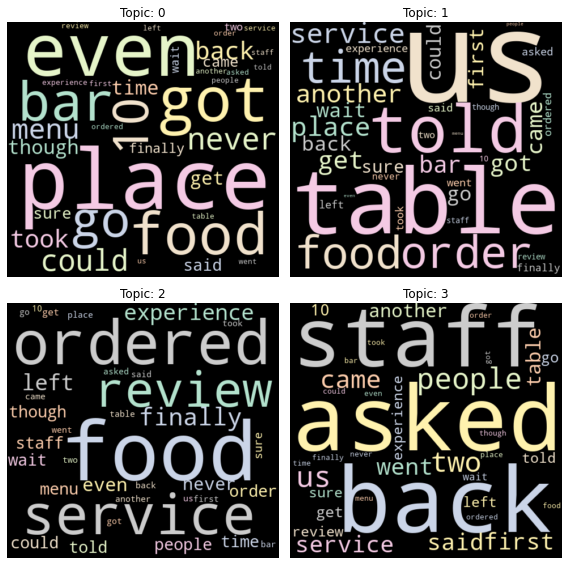

In [349]:
#Visoualize Topics
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math

num_top_words=100
f, axarr = plt.subplots(2, 2, figsize=(8, 8));



for topic_idx, topic in enumerate(lda.components_):
    # create a dataframe with two columns (word, weight) for each topic
    
    # create a word:count dictionary
    f={tf_feature_names[i]:topic[i] for i in topic.argsort()[::-1][0:num_top_words]}
    
    # generate wordcloud in subplots
    wordcloud = WordCloud(width=480, height=450, margin=0, background_color="black",colormap="Pastel2_r");
    _ = wordcloud.generate_from_frequencies(frequencies=f);
    
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].imshow(wordcloud, interpolation="bilinear");
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].set_title("Topic: "+str(topic_idx));
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].axis('off')

plt.tight_layout()
plt.show()